In [1]:
# Loading the teams data
import pandas as pd
import json
from mplsoccer import Pitch, Sbopen, VerticalPitch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import os

os.environ['QT_QPA_PLATFORM'] = 'offscreen'
team_name = "Poland"



path_teams='data/teams.json'
path_matches='data/matches_World_Cup.json'
path_events_world_cup = "data/events_World_Cup.json"
path_players = 'data/players.json'
path_tags = 'data/tags2name.csv'
path_events_name = 'data/eventid2name.csv'



# Data loading optimization
def load_json(path):
    with open(path, encoding='utf-8') as f:
        return pd.DataFrame(json.load(f))

df_teams = load_json(path_teams)
df_matches = load_json(path_matches)
world_cup_events = load_json(path_events_world_cup)
players_world_cup = load_json(path_players)


def get_team_wyId(team_name):
    team_wyId = df_teams[df_teams['name'] == team_name]['wyId'].values
    if len(team_wyId) > 0:
        return int(team_wyId[0])
    else:
        return None

# Example usage:

team_wyId = get_team_wyId(team_name)
print(f"The wyId for {team_name} is {team_wyId}")

The wyId for Poland is 13869


In [2]:
# Selecting the matches of the Polish team. Their team ID is 13869
polish_matches = df_matches[df_matches['teamsData'].apply(lambda x: '13869' in x.keys())]
polish_matches_list = list(polish_matches.wyId)

#structure of data
polish_matches_events = world_cup_events[world_cup_events.matchId.isin(polish_matches_list)]
polish_matches_events.head()


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
65302,8,Simple pass,[{'id': 1801}],25898,"[{'y': 52, 'x': 50}, {'y': 49, 'x': 32}]",2057996,Pass,19314,1H,1.294053,85,259374890
65303,8,High pass,[{'id': 1802}],25726,"[{'y': 49, 'x': 32}, {'y': 43, 'x': 84}]",2057996,Pass,19314,1H,2.924520,83,259374898
65304,8,Head pass,[{'id': 1801}],99661,"[{'y': 57, 'x': 16}, {'y': 64, 'x': 30}]",2057996,Pass,13869,1H,6.764062,82,259374882
65305,7,Touch,[],25537,"[{'y': 64, 'x': 30}, {'y': 53, 'x': 28}]",2057996,Others on the ball,13869,1H,8.539952,72,259374883
65306,1,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",25747,"[{'y': 47, 'x': 72}, {'y': 50, 'x': 73}]",2057996,Duel,19314,1H,9.772125,13,259374903


In [43]:
# Flatten the nested lists of team IDs into a single list
list_of_opponents = [item for sublist in polish_matches['teamsData'].apply(lambda x: list(x.keys())) for item in sublist]

# Remove Poland's team ID from the list to get only opponents
list_of_opponents = [team_id for team_id in list_of_opponents if team_id != '13869']

names_of_opponents=[df_teams[df_teams['wyId']==int(x)]['name'].values[0] for x in list_of_opponents]
names_of_opponents

# Get the names of the opponents
def get_opponent_name():
    input_opponent =input("Enter the name of the opponent: ")
    if input_opponent in names_of_opponents:
        return input_opponent
    else:
        print("Invalid input. Please enter a valid opponent name from:", names_of_opponents)
        return get_opponent_name()

opponent_name = get_opponent_name()

selected_opponent_id=list_of_opponents[names_of_opponents.index(opponent_name)]

filtered_matches = polish_matches[polish_matches['teamsData'].apply(lambda x: selected_opponent_id in x.keys())]
match_id=filtered_matches['wyId'].iloc[0]

Invalid input. Please enter a valid opponent name from: ['Japan', 'Colombia', 'Senegal']


In [44]:
# Filter the matches where team IDs are 13869 and selected_opponent_id
match_id

2058000

In [10]:
# Loading the players data

polish_players_wc = players_world_cup[players_world_cup['passportArea'].apply(lambda x: x['name'])=='Poland']

polish_players = polish_players_wc[['shortName','wyId','foot','lastName']].rename(columns={'wyId':'playerId'})

In [5]:
tags = pd.read_csv(path_tags)
events_name = pd.read_csv(path_events_name)
tags.head()

,Tag,Label,Description
0,101,Goal,Goal
1,102,own_goal,Own goal
2,301,assist,Assist
3,302,keyPass,Key pass
4,1901,counter_attack,Counter attack


In [6]:
#Data Cleaning



#matches_events
polish_matches_events[['y', 'x', 'end_y', 'end_x']] = polish_matches_events['positions'].apply(lambda x: pd.Series({'y': x[0]['y'], 'x': x[0]['x'], 'end_y': x[1]['y'], 'end_x': x[1]['x']}))
polish_matches_events = polish_matches_events.drop(columns=['positions'], axis=1)
polish_matches_events = polish_matches_events.set_index('id')

#players_info

# extract players info
players_info = []
for match_id, team_data in zip(polish_matches['wyId'], polish_matches['teamsData']):
    for team_id, team_info in team_data.items():
        for player_info in team_info['formation']['lineup']:
            player_info['teamId'] = team_id
            player_info['inFormation'] = True
            player_info['sub'] = False
            player_info['minute'] = None
            player_info['playerIn'] = ''
            player_info['playerOut'] = ''
            player_info['matchId'] = match_id
            players_info.append(player_info)
        for player_info in team_info['formation']['bench']:
            player_info['teamId'] = team_id
            player_info['inFormation'] = False
            player_info['sub'] = False
            player_info['minute'] = None
            player_info['playerIn'] = ''
            player_info['playerOut'] = ''
            player_info['matchId'] = match_id
            players_info.append(player_info)
        for sub_info in team_info['formation']['substitutions']:
            player_in = [p for p in players_info if p['playerId'] == sub_info['playerIn']][0]
            player_out = [p for p in players_info if p['playerId'] == sub_info['playerOut']][0]
            player_out['sub'] = True
            player_out['minute'] = sub_info['minute']
            player_out['playerIn'] = sub_info['playerIn']
            player_out['playerOut'] = sub_info['playerOut']
            player_out['matchId'] = match_id
            player_in['inFormation'] = False
            player_in['sub'] = True
            player_in['minute'] = sub_info['minute']
            player_in['playerIn'] = sub_info['playerIn']
            player_in['playerOut'] = sub_info['playerOut']
            player_in['matchId'] = match_id

# create a DataFrame from the players info
players_df = pd.DataFrame(players_info)

# select the desired columns
players_df = players_df[['matchId', 'teamId', 'playerId', 'inFormation', 'sub', 'minute', 'playerIn', 'playerOut']]

# print the DataFrame
polish_players = pd.merge(players_df, polish_players, on='playerId', how='left')

# filter only players for polish team
polish_players = polish_players[polish_players.teamId == '13869']

def decode_name(name):
    if isinstance(name, str):
        return name.encode('latin1').decode('unicode_escape')
    return name

polish_players['lastName'] = polish_players['lastName'].apply(decode_name)

#matches_info

polish_matches = polish_matches[['wyId', 'label']].rename(columns={"wyId": "matchId"})

polish_matches_events = polish_matches_events.merge(polish_matches, on='matchId', how='left')

# Convert the 'tags' column to a list of tag IDs
polish_matches_events['tags'] = polish_matches_events['tags'].apply(lambda tag_list: [tag['id'] for tag in tag_list])

# One-hot encode the tag IDs using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_dummies = pd.DataFrame(mlb.fit_transform(polish_matches_events['tags']), columns=mlb.classes_, index=polish_matches_events.index)

# Create a mapping of tag IDs to labels
id_to_label = tags.set_index('Tag')['Label'].to_dict()

# Rename the columns of tags_dummies using the id_to_label mapping
tags_dummies.columns = tags_dummies.columns.map(id_to_label)

# Merge the one-hot encoded DataFrame with the original polish_matches_events dataset
polish_matches_events = pd.concat([polish_matches_events, tags_dummies], axis=1)

# Drop the original 'tags' column
polish_matches_events = polish_matches_events.drop(columns=['tags'])

polish_matches_events.head()


/tmp/ipykernel_24241/2447643186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polish_matches_events[['y', 'x', 'end_y', 'end_x']] = polish_matches_events['positions'].apply(lambda x: pd.Series({'y': x[0]['y'], 'x': x[0]['x'], 'end_y': x[1]['y'], 'end_x': x[1]['x']}))
/tmp/ipykernel_24241/2447643186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polish_matches_events[['y', 'x', 'end_y', 'end_x']] = polish_matches_events['positions'].apply(lambda x: pd.Series({'y': x[0]['y'], 'x': x[0]['x'], 'end_y

,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,y,...,Feint,missed ball,interception,sliding_tackle,yellow_card,accurate,not accurate,counter_attack,dangerous_ball_lost,blocked
0,8,Simple pass,25898,2057996,Pass,19314,1H,1.294053,85,52,...,0,0,0,0,0,1,0,0,0,0
1,8,High pass,25726,2057996,Pass,19314,1H,2.924520,83,49,...,0,0,0,0,0,0,1,0,0,0
2,8,Head pass,99661,2057996,Pass,13869,1H,6.764062,82,57,...,0,0,0,0,0,1,0,0,0,0
3,7,Touch,25537,2057996,Others on the ball,13869,1H,8.539952,72,64,...,0,0,0,0,0,0,0,0,0,0
4,1,Ground loose ball duel,25747,2057996,Duel,19314,1H,9.772125,13,47,...,0,0,0,0,0,0,1,0,0,0


In [7]:
polish_players_names = polish_players.loc[:, ['playerId', 'lastName']].drop_duplicates(subset=['playerId', 'lastName'])
polish_players_names.head()

,playerId,lastName
23,225324,Kurzawa
24,99902,Zieliński
25,25537,Krychowiak
26,99381,Jędrzejczyk
27,33032,Grosicki


In [8]:
df_polish_mathes_events = polish_matches_events[(polish_matches_events.eventName=='Shot') & (polish_matches_events.teamId == 13869)].rename(columns={'label': 'matchName'})
df_polish_mathes_events = pd.merge(df_polish_mathes_events, polish_players_names, on='playerId')


# Define a custom function to determine the shot outcome
def shot_outcome(row):
    if row['Goal'] == 1:
        return 'Goal'
    elif row['accurate'] == 1:
        return 'Accurate'
    elif row['not accurate'] == 1:
        return 'Missed'

# Apply the custom function to create the 'shot_outcome' column
df_polish_mathes_events['shot_outcome'] = df_polish_mathes_events.apply(shot_outcome, axis=1)

df_polish_mathes_events.head()




,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,y,...,interception,sliding_tackle,yellow_card,accurate,not accurate,counter_attack,dangerous_ball_lost,blocked,lastName,shot_outcome
0,10,Shot,33032,2057996,Shot,13869,1H,1154.346261,100,58,...,0,0,0,0,1,0,0,0,Grosicki,Missed
1,10,Shot,14817,2057996,Shot,13869,1H,1364.806401,100,50,...,0,0,0,0,1,0,0,0,Lewandowski,Missed
2,10,Shot,14798,2057996,Shot,13869,2H,630.815538,100,67,...,0,0,0,0,1,0,0,0,Piszczek,Missed
3,10,Shot,33032,2057996,Shot,13869,2H,1278.420087,100,59,...,0,0,0,0,1,0,0,1,Grosicki,Missed
4,10,Shot,99452,2057996,Shot,13869,2H,1477.066196,100,53,...,0,0,0,0,1,0,0,0,Milik,Missed


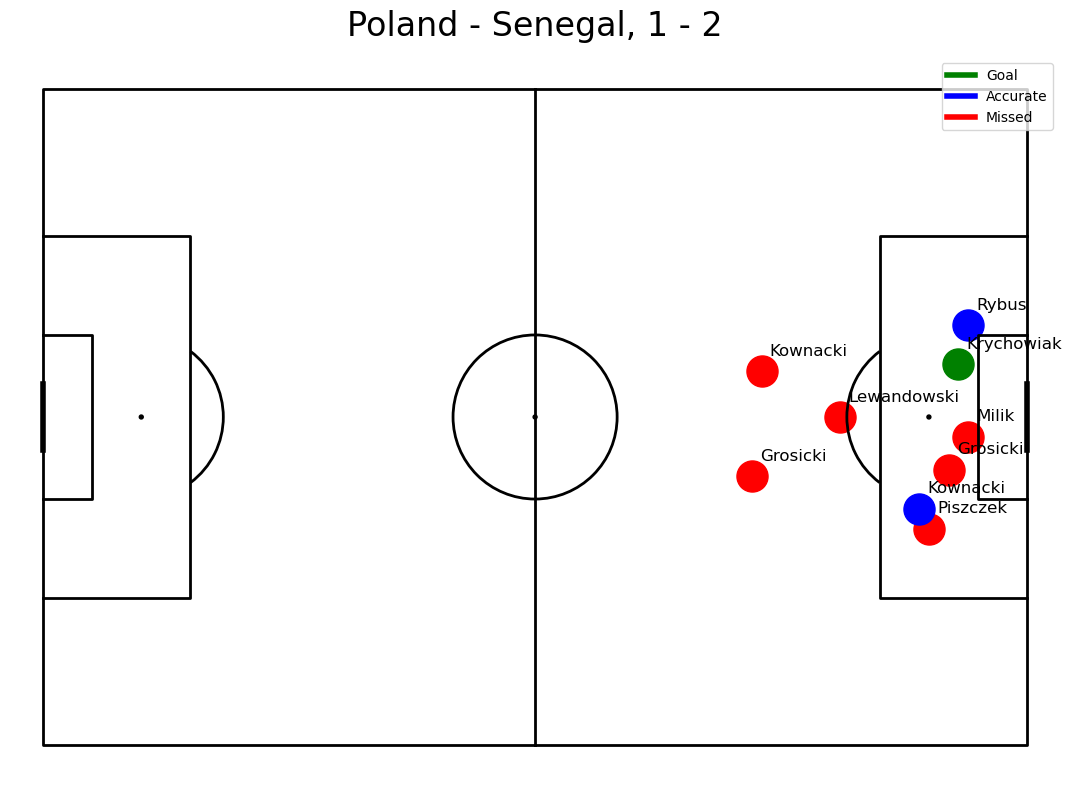

<Figure size 640x480 with 0 Axes>

In [9]:

plot_df = df_polish_mathes_events[(df_polish_mathes_events.matchId == 2057996)].copy()
pitch = Pitch(line_zorder=2, line_color="black")
fig, ax = pitch.draw(figsize=(12, 8))
# Size of the pitch in yards
pitchLengthX = 120
pitchWidthY = 80
# Standardize the 'x' and 'y' values
plot_df['x_standardized'] = plot_df['x'] / 100 * pitchLengthX
plot_df['y_standardized'] = plot_df['y'] / 100 * pitchWidthY
# Plot the shots by looping through them.
for i, shot in plot_df.iterrows():
    # Get the information
    x = shot['x_standardized']
    y = shot['y_standardized']
    # Set circle size
    circleSize = 2

    # Set color based on shot outcome
    if shot.shot_outcome == 'Goal':
        pitch.scatter(x, y, alpha=1, s=500, color='green', ax=ax)
        pitch.annotate(shot["lastName"], (x + 1, y - 2), ax=ax, fontsize=12)
    elif shot.shot_outcome == 'Accurate':
        pitch.scatter(x, y, alpha=1, s=500, color='blue', ax=ax)
        pitch.annotate(shot["lastName"], (x + 1, y - 2), ax=ax, fontsize=12)
    elif shot.shot_outcome == 'Missed':
        pitch.scatter(x, y, alpha=1, s=500, color='red', ax=ax)
        pitch.annotate(shot["lastName"], (x + 1, y - 2), ax=ax, fontsize=12)

# Create legend
goal_legend = plt.Line2D([0], [0], color="green", lw=4)
accurate_legend = plt.Line2D([0], [0], color="blue", lw=4)
missed_legend = plt.Line2D([0], [0], color="red", lw=4)
ax.legend([goal_legend, accurate_legend, missed_legend], ['Goal', 'Accurate', 'Missed'], loc='upper right')

# Set title
match_name = plot_df['matchName'].iloc[0]  # Get the match name from the first row of plot_df
fig.suptitle(match_name, fontsize=24)
fig.set_size_inches(12, 8)
plt.show()
file_name = '{}_plot.jpg'.format(match_name)
plt.savefig("figures/"+file_name)



In [10]:
df_polish_mathes_events = polish_matches_events[(polish_matches_events.eventName=='Pass') & (polish_matches_events.teamId == 13869)].rename(columns={'label': 'matchName'})
df_polish_mathes_events = pd.merge(df_polish_mathes_events, polish_players_names, on='playerId')
df_polish_mathes_events.head()

,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,y,...,missed ball,interception,sliding_tackle,yellow_card,accurate,not accurate,counter_attack,dangerous_ball_lost,blocked,lastName
0,8,Head pass,99661,2057996,Pass,13869,1H,6.764062,82,57,...,0,0,0,0,1,0,0,0,0,Rangel Cionek
1,8,Simple pass,99438,2057996,Pass,13869,1H,29.277501,85,25,...,0,0,0,0,1,0,0,0,0,Pazdan
2,8,Simple pass,99661,2057996,Pass,13869,1H,33.085403,85,60,...,0,0,0,0,1,0,0,0,0,Rangel Cionek
3,8,Simple pass,25537,2057996,Pass,13869,1H,39.122156,85,54,...,0,0,0,0,1,0,0,0,0,Krychowiak
4,8,Simple pass,99438,2057996,Pass,13869,1H,40.866062,85,19,...,0,0,0,0,1,0,0,0,0,Pazdan


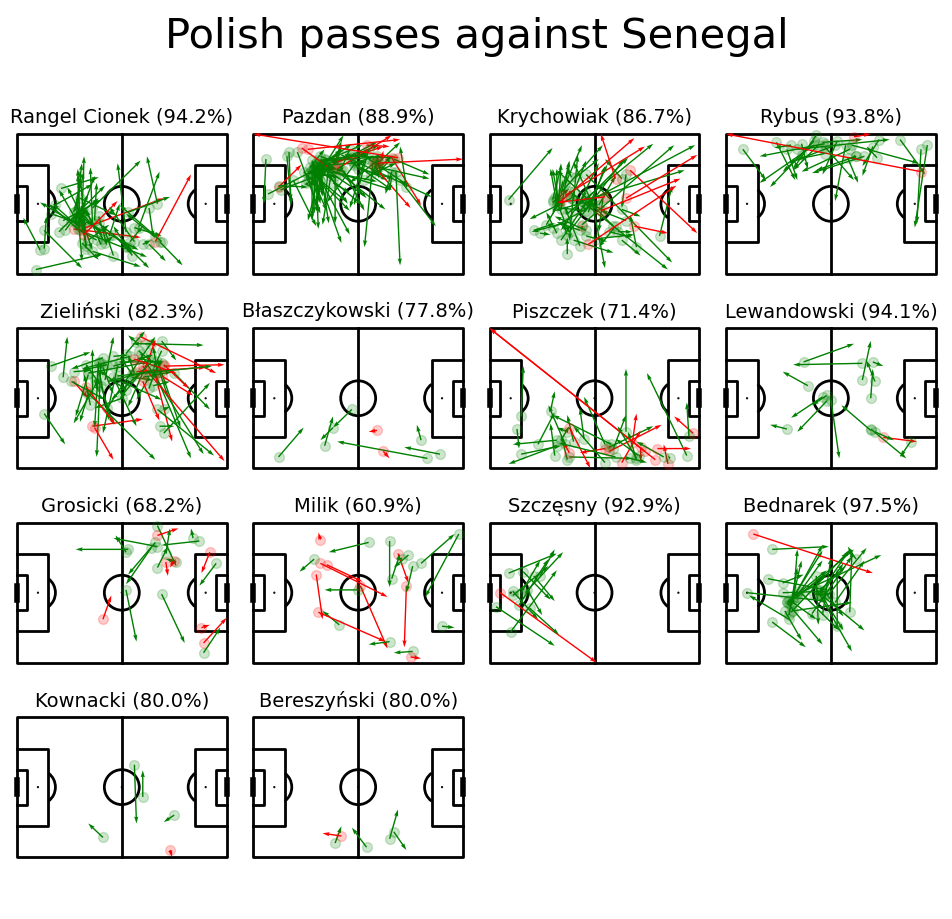

<Figure size 640x480 with 0 Axes>

In [11]:
#prepare the dataframe of passes by England that were no-throw ins
mask_poland = (df_polish_mathes_events.subEventName != "Throw-in") & (df_polish_mathes_events.matchId == 2057996)
df_passes = df_polish_mathes_events.loc[mask_poland, ['x', 'y', 'end_x', 'end_y', 'lastName', 'accurate']]
#get the list of all players who made a pass
names = df_passes['lastName'].unique()

#draw 4x4 pitches
pitchLengthX = 120
pitchWidthY = 80
pitch = Pitch(line_color='black', pad_top=20, pitch_length=pitchLengthX, pitch_width=pitchWidthY)

fig, axs = pitch.grid(ncols=4, nrows=4, grid_height=0.85, title_height=0.06, axis=False,
                      endnote_height=0.04, title_space=0.04, endnote_space=0.01)

#standarize x and y
df_passes['x'] = df_passes['x'] / 100 * pitchLengthX
df_passes['y'] = df_passes['y'] / 100 * pitchWidthY
df_passes['end_x'] = df_passes['end_x'] / 100 * pitchLengthX
df_passes['end_y'] = df_passes['end_y'] / 100 * pitchWidthY

#for each player
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    player_df = df_passes.loc[df_passes["lastName"] == name]

    # Calculate the share of accurate passes
    total_passes = len(player_df)
    accurate_passes = len(player_df[player_df['accurate'] == 1])
    accuracy_share = accurate_passes / total_passes * 100
    
    # Put player name and accuracy share over the plot
    ax.text(60, -10, f"{name} ({accuracy_share:.1f}%)", ha='center', va='center', fontsize=14)
    
    # Plot arrow and scatter
    for idx, row in player_df.iterrows():
        arrow_color = "green" if row['accurate'] == 1 else "red"
        pitch.arrows(row.x, row.y,
                     row.end_x, row.end_y, color=arrow_color, ax=ax, width=1)
        pitch.scatter(row.x, row.y, alpha=0.2, s=50, color=arrow_color, ax=ax)

#We have more than enough pitches - remove them
for ax in axs['pitch'][-1, 16 - len(names):]:
    ax.remove()

#Another way to set title using mplsoccer
axs['title'].text(0.5, 0.5, 'Polish passes against Senegal', ha='center', va='center', fontsize=30)
plt.show()
plt.savefig("figures/"+'Polish_passes.jpg')


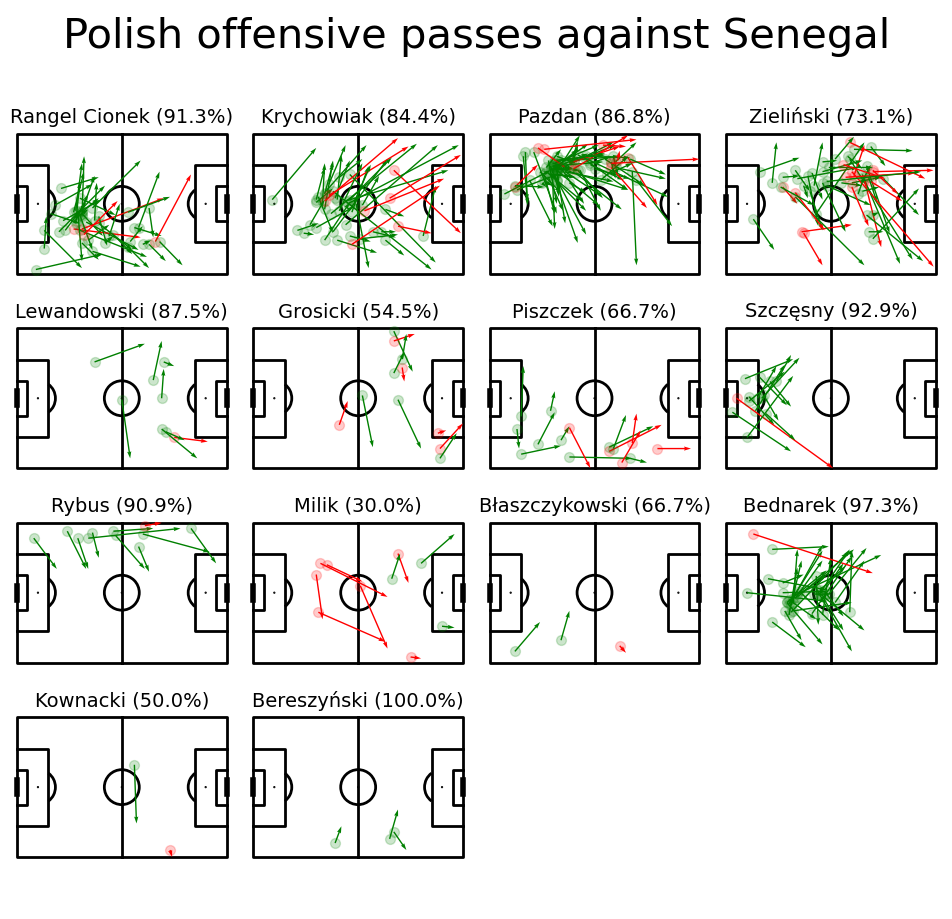

<Figure size 640x480 with 0 Axes>

In [12]:
#prepare the dataframe of passes by England that were no-throw ins
mask_poland = (df_polish_mathes_events.subEventName != "Throw-in") & (df_polish_mathes_events.matchId == 2057996)
df_passes = df_polish_mathes_events.loc[mask_poland, ['x', 'y', 'end_x', 'end_y', 'lastName', 'accurate']]
df_passes = df_passes[df_passes.end_x > df_passes.x]

#get the list of all players who made a pass
names = df_passes['lastName'].unique()

#draw 4x4 pitches
pitchLengthX = 120
pitchWidthY = 80
pitch = Pitch(line_color='black', pad_top=20, pitch_length=pitchLengthX, pitch_width=pitchWidthY)

fig, axs = pitch.grid(ncols=4, nrows=4, grid_height=0.85, title_height=0.06, axis=False,
                      endnote_height=0.04, title_space=0.04, endnote_space=0.01)

#standarize x and y
df_passes['x'] = df_passes['x'] / 100 * pitchLengthX
df_passes['y'] = df_passes['y'] / 100 * pitchWidthY
df_passes['end_x'] = df_passes['end_x'] / 100 * pitchLengthX
df_passes['end_y'] = df_passes['end_y'] / 100 * pitchWidthY

#for each player
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    player_df = df_passes.loc[df_passes["lastName"] == name]

    # Calculate the share of accurate passes
    total_passes = len(player_df)
    accurate_passes = len(player_df[player_df['accurate'] == 1])
    accuracy_share = accurate_passes / total_passes * 100
    
    # Put player name and accuracy share over the plot
    ax.text(60, -10, f"{name} ({accuracy_share:.1f}%)", ha='center', va='center', fontsize=14)
    
    # Plot arrow and scatter
    for idx, row in player_df.iterrows():
        arrow_color = "green" if row['accurate'] == 1 else "red"
        pitch.arrows(row.x, row.y,
                     row.end_x, row.end_y, color=arrow_color, ax=ax, width=1)
        pitch.scatter(row.x, row.y, alpha=0.2, s=50, color=arrow_color, ax=ax)

#We have more than enough pitches - remove them
for ax in axs['pitch'][-1, 16 - len(names):]:
    ax.remove()

#Another way to set title using mplsoccer
axs['title'].text(0.5, 0.5, 'Polish offensive passes against Senegal', ha='center', va='center', fontsize=30)
plt.show()
plt.savefig("figures/"+'Polish_offensive_passes.jpg')


In [19]:
df = polish_matches_events[(polish_matches_events.matchId == 2057996) & (polish_matches_events.teamId == 13869) & (polish_matches_events.eventName == 'Pass') & (polish_matches_events.matchPeriod == '1H')].rename(columns={'label': 'matchName'})
df['next_player'] = df['playerId'].shift(-1)
df.loc[df['accurate'] != 1, 'next_player'] = None
df = df[df['next_player'].notnull()]
df = df[['playerId','x', 'y', 'end_x', 'end_y', 'eventSec', 'next_player']]

df.head()

,playerId,x,y,end_x,end_y,eventSec,next_player
2,99661,16,57,30,64,6.764062,99438.0
8,99438,30,25,28,60,29.277501,99661.0
9,99661,28,60,34,54,33.085403,25537.0
10,25537,34,54,38,19,39.122156,99438.0
11,99438,38,19,62,16,40.866062,99391.0


In [20]:
polish_sen = polish_players[(polish_players.matchId == 2057996) & (polish_players.teamId == '13869')]
polish_sen = polish_sen[['playerId', 'minute', 'lastName']]
players = polish_sen[['playerId', 'lastName']].drop_duplicates()
players.head()

,playerId,lastName
31,99833,Bereszyński
33,240032,Bednarek
34,240042,Kownacki
36,99452,Milik
37,14798,Piszczek


In [21]:
merged_df = df.merge(players, left_on='playerId', right_on='playerId', how='left')
merged_df = merged_df.merge(players, left_on='next_player', right_on='playerId', how='left', suffixes=('', '_next'))
merged_df.drop('playerId_next', axis=1, inplace=True)
merged_df.drop(['playerId', 'next_player', 'eventSec'], axis=1, inplace=True)
merged_df.head()

,x,y,end_x,end_y,lastName,lastName_next
0,16,57,30,64,Rangel Cionek,Pazdan
1,30,25,28,60,Pazdan,Rangel Cionek
2,28,60,34,54,Rangel Cionek,Krychowiak
3,34,54,38,19,Krychowiak,Pazdan
4,38,19,62,16,Pazdan,Rybus


In [22]:
df_pass = merged_df.copy()

pitchLengthX = 120
pitchWidthY = 80


df_pass['x'] = df_pass['x'] / 100 * pitchLengthX
df_pass['y'] = df_pass['y'] / 100 * pitchWidthY
df_pass['end_x'] = df_pass['end_x'] / 100 * pitchLengthX
df_pass['end_y'] = df_pass['end_y'] / 100 * pitchWidthY

scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["lastName"].unique()):
    passx = df_pass.loc[df_pass["lastName"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["lastName_next"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["lastName"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["lastName_next"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "lastName"] = name
    # Make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    # Calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["lastName"] == name].count().iloc[0]

# Adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)
scatter_df.head()

,lastName,x,y,no,marker_size
0,Rangel Cionek,40.580282,48.552113,37.0,1233.333333
1,Pazdan,42.256180,20.458427,45.0,1500.000000
2,Krychowiak,51.632000,41.450667,38.0,1266.666667
3,Rybus,59.080000,5.706667,16.0,533.333333
4,Zieliński,61.458462,22.523077,32.0,1066.666667


In [23]:
# Counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["lastName"], x["lastName_next"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)

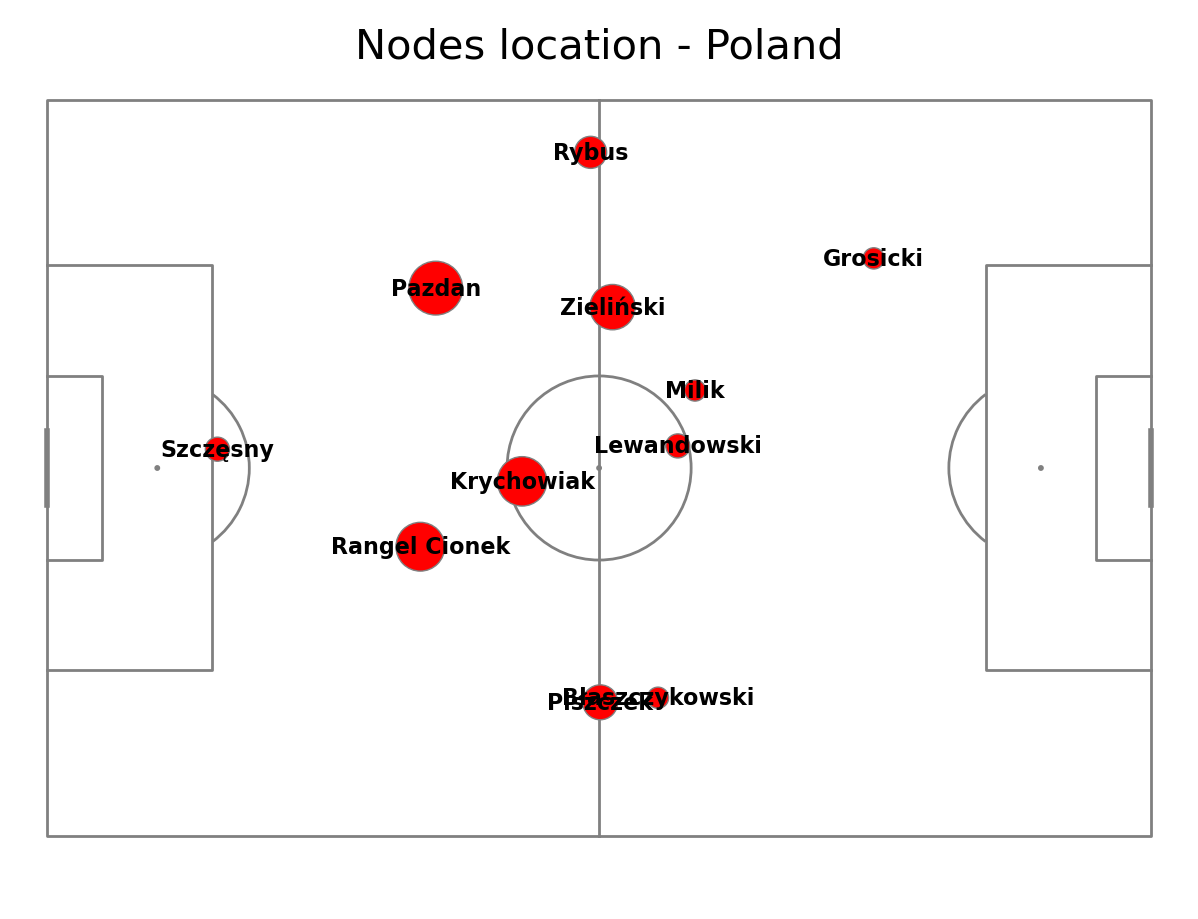

In [25]:
# Drawing pitch

pitchLengthX = 120
pitchWidthY = 80
pitch = Pitch(line_color='grey', pitch_length=pitchLengthX, pitch_width=pitchWidthY)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
# Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder=3)
# Annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.lastName, xy=(row.x, row.y), c='black', va='center', ha='center', weight="bold", size=16, ax=ax["pitch"], zorder=4)

fig.suptitle("Nodes location - Poland", fontsize=30)
plt.show()


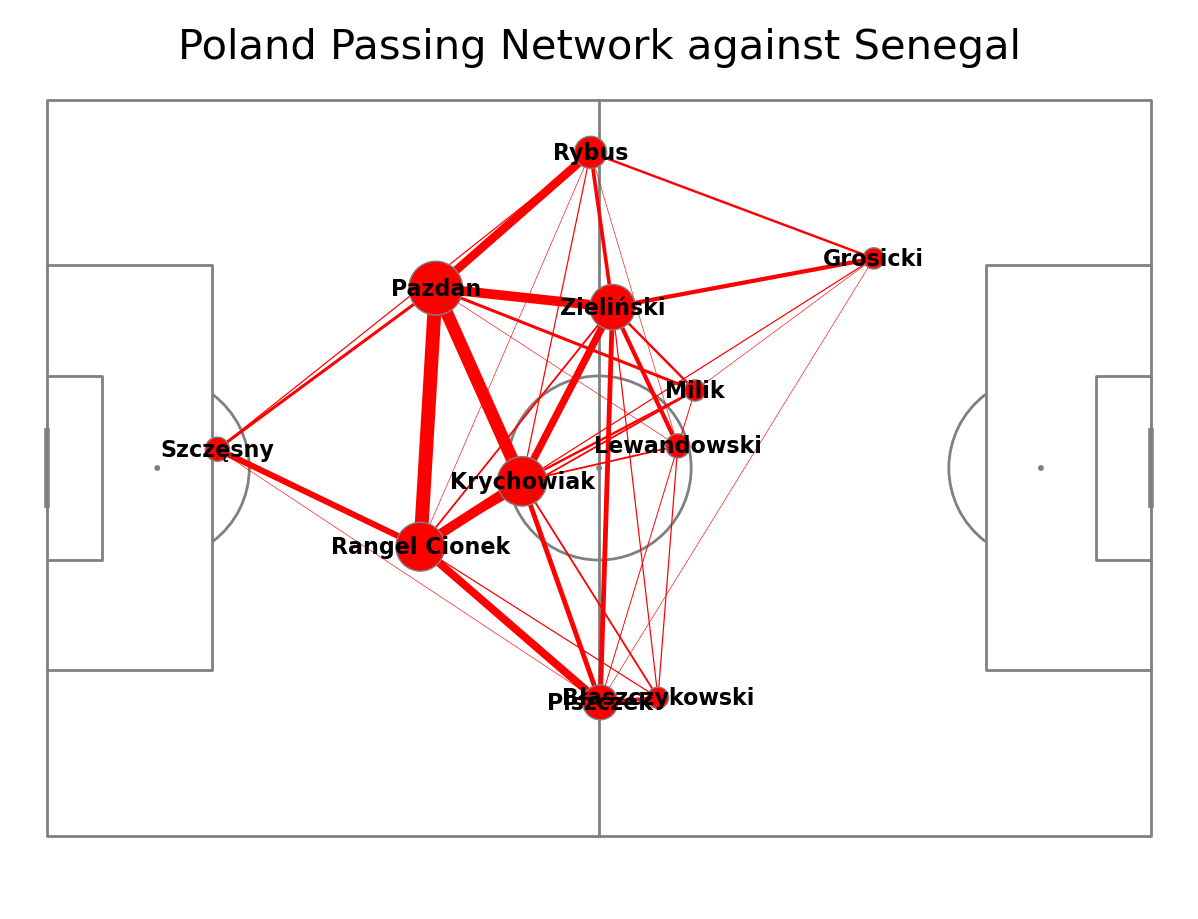

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder=3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.lastName, xy=(row.x, row.y), c='black', va='center', ha='center', weight="bold", size=16, ax=ax["pitch"], zorder=4)

for i, row in lines_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]
    # Take the average location of players to plot a line between them
    player1_x = scatter_df.loc[scatter_df["lastName"] == player1]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df["lastName"] == player1]['y'].iloc[0]
    player2_x = scatter_df.loc[scatter_df["lastName"] == player2]['x'].iloc[0]
    player2_y = scatter_df.loc[scatter_df["lastName"] == player2]['y'].iloc[0]
    num_passes = row["pass_count"]
    # Adjust the line width so that the more passes, the wider the line
    line_width = (num_passes / lines_df['pass_count'].max() * 10)
    # Plot lines on the pitch
    pitch.lines(player1_x, player1_y, player2_x, player2_y,
                alpha=1, lw=line_width, zorder=2, color="red", ax=ax["pitch"])

fig.suptitle("Poland Passing Network against Senegal", fontsize=30)
plt.show()
plt.savefig("figures/"+'Polish_Passing_Network.jpg')


In [27]:
#calculate number of successful passes by player
no_passes = df_pass.groupby(['lastName']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max()
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum()
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.11902654867256637


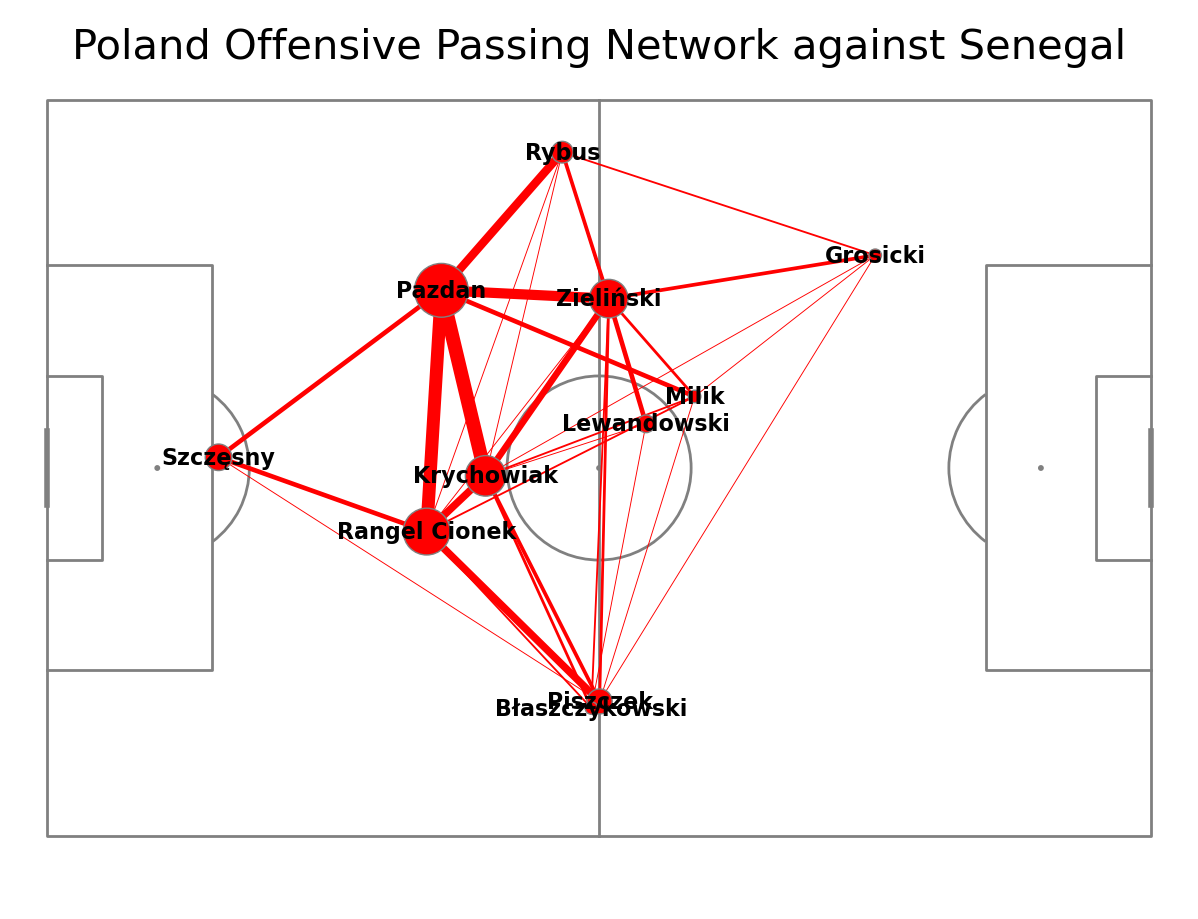

<Figure size 640x480 with 0 Axes>

In [28]:
df_pass = merged_df.copy()

pitchLengthX = 120
pitchWidthY = 80


df_pass['x'] = df_pass['x'] / 100 * pitchLengthX
df_pass['y'] = df_pass['y'] / 100 * pitchWidthY
df_pass['end_x'] = df_pass['end_x'] / 100 * pitchLengthX
df_pass['end_y'] = df_pass['end_y'] / 100 * pitchWidthY

df_pass = df_pass[df_pass.end_x > df_pass.x]

scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["lastName"].unique()):
    passx = df_pass.loc[df_pass["lastName"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["lastName_next"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["lastName"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["lastName_next"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "lastName"] = name
    # Make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    # Calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["lastName"] == name].count().iloc[0]

# Adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

# Counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["lastName"], x["lastName_next"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)


# Drawing pitch

pitchLengthX = 120
pitchWidthY = 80
# pitch = Pitch(line_color='grey', pitch_length=pitchLengthX, pitch_width=pitchWidthY)
# fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
#                      endnote_height=0.04, title_space=0, endnote_space=0)
# # Scatter the location on the pitch
# pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder=3)
# Annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.lastName, xy=(row.x, row.y), c='black', va='center', ha='center', weight="bold", size=16, ax=ax["pitch"], zorder=4)

# Plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder=3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.lastName, xy=(row.x, row.y), c='black', va='center', ha='center', weight="bold", size=16, ax=ax["pitch"], zorder=4)

for i, row in lines_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]
    # Take the average location of players to plot a line between them
    player1_x = scatter_df.loc[scatter_df["lastName"] == player1]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df["lastName"] == player1]['y'].iloc[0]
    player2_x = scatter_df.loc[scatter_df["lastName"] == player2]['x'].iloc[0]
    player2_y = scatter_df.loc[scatter_df["lastName"] == player2]['y'].iloc[0]
    num_passes = row["pass_count"]
    # Adjust the line width so that the more passes, the wider the line
    line_width = (num_passes / lines_df['pass_count'].max() * 10)
    # Plot lines on the pitch
    pitch.lines(player1_x, player1_y, player2_x, player2_y,
                alpha=1, lw=line_width, zorder=2, color="red", ax=ax["pitch"])

fig.suptitle("Poland Offensive Passing Network against Senegal", fontsize=30)
plt.show()
plt.savefig("figures/"+'Polish_Offensive_Passing_Network.jpg')


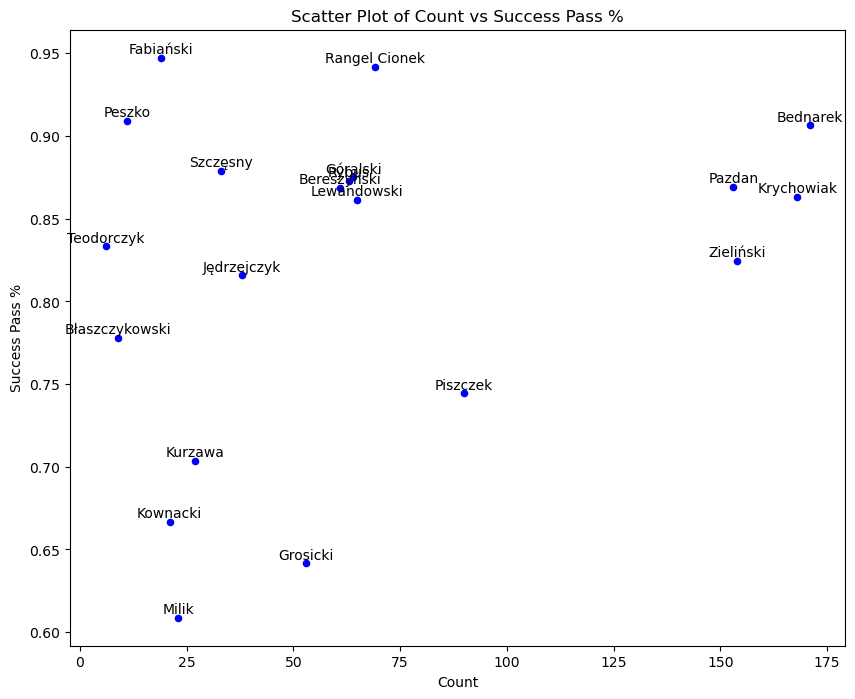

<Figure size 640x480 with 0 Axes>

In [29]:
df_polish_mathes_events = polish_matches_events[(polish_matches_events.eventName=='Pass') & (polish_matches_events.teamId == 13869)].rename(columns={'label': 'matchName'})
df_polish_mathes_events = pd.merge(df_polish_mathes_events, polish_players_names, on='playerId')
df_polish_mathes_events = df_polish_mathes_events[['lastName', 'accurate']]
# group by lastName and compute count and sum
df_polish_mathes_events = df_polish_mathes_events.groupby('lastName').agg({'accurate': ['count', 'sum']})

# rename the columns
df_polish_mathes_events.columns = ['count', 'sum']

# reset the index
df_polish_mathes_events = df_polish_mathes_events.reset_index()
df_polish_mathes_events['sucPass'] = df_polish_mathes_events['sum'] / df_polish_mathes_events['count']

# set the plot size
fig, ax = plt.subplots(figsize=(10, 8))

# create the scatter plot
df_polish_mathes_events.plot(kind='scatter', x='count', y='sucPass', color='blue', ax=ax)

# set the axis labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Success Pass %')
ax.set_title('Scatter Plot of Count vs Success Pass %')

# add labels to the scatter plot
for i, row in df_polish_mathes_events.iterrows():
    ax.text(row['count'], row['sucPass']+0.005, row['lastName'], ha='center', va='center')

# display the plot
plt.show()
plt.savefig("figures/"+'Passing_Scatterplot.jpg')

In [2]:
# Loading the teams data
import pandas as pd
import json
from mplsoccer import Pitch, Sbopen, VerticalPitch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import os

os.environ['QT_QPA_PLATFORM'] = 'offscreen'


path_teams='data/teams.json'
path_matches='data/matches_World_Cup.json'
path_events_world_cup = "data/events_World_Cup.json"
path_players = 'data/players.json'
path_tags = 'data/tags2name.csv'
path_events_name = 'data/eventid2name.csv'



# Data loading optimization
def load_json(path):
    with open(path, encoding='utf-8') as f:
        return pd.DataFrame(json.load(f))

df_teams = load_json(path_teams)

In [3]:
def get_team_wyId(team_name):
    team_wyId = df_teams[df_teams['name'] == team_name]['wyId'].values
    if len(team_wyId) > 0:
        return team_wyId[0]
    else:
        return None

# Example usage:
team_name = "Poland"
team_wyId = get_team_wyId(team_name)
print(f"The wyId for {team_name} is {team_wyId}")

The wyId for Poland is 13869


,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,"{'name': 'Tunisia', 'id': 788, 'alpha3code': '...",72,Ali,,Ma\u00e2loul,16041,1990-01-01,175,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Tunisia', 'id': 788, 'alpha3code': '...",120839,left,A. Ma\u00e2loul,null
3599,"{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",76,Carlos Alberto,,C\u00e1ceda Oyaguez,15591,1991-09-27,183,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",114736,right,C. C\u00e1ceda,null
3600,"{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",78,Miguel Gianpierre,,Araujo Blanco,12072,1994-10-24,179,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",114908,right,M. Araujo,null
3601,"{'name': 'Morocco', 'id': 504, 'alpha3code': '...",70,Ahmed Reda,,Tagnaouti,16183,1996-04-05,182,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Morocco', 'id': 504, 'alpha3code': '...",285583,right,A. Tagnaouti,null


In [50]:
# Extract unique player IDs from world_cup_events
unique_player_ids = world_cup_events['playerId'].unique()

# Filter players_world_cup to include only the players present in world_cup_events
filtered_players = players_world_cup[players_world_cup['wyId'].isin(unique_player_ids)]

# Select only the relevant columns
filtered_players = filtered_players[['wyId', 'firstName', 'lastName']]

# Rename the 'wyId' column to 'playerId' to match the column name in world_cup_events
filtered_players = filtered_players.rename(columns={'wyId': 'playerId'})

# Merge the filtered players with the world_cup_events DataFrame
merged_df = world_cup_events.merge(filtered_players, on='playerId', how='left')

# Display the merged DataFrame
merged_df[['playerId', 'firstName', 'lastName']].to_csv('test.csv')#.head()

In [53]:
import numpy as np
import pandas as pd

polish_players=pd.read_csv('polish_players.csv')

ids=np.array([ 14763,  14730,  94764,  94828,  94630,  37896,  14749,  95010,
        94695,    703,  20517,  95108,  94650, 137653, 137661, 101592,
        94814,  95349,  94922,  14816,  14836,  94831,  14929, 225324,
        99902,  25537,  99381,  33032,  21097,  14817,   7847,  99833,
       100140, 240032, 240042,  99438,  99452,  14798,   8121,  14804,
       138174,  99391,   7849,  99479,  15282,  99661,   4814,  91019,
         3450, 246928,  70136,  25662, 257762,  70096,  91702, 256634,
        20751,   3531,  90999,  91002,  91039,  91381,  20764,  91082,
        91156, 255738,  37831,  91502,  15054,  25898,  32793,  26115,
        25726, 375348, 448079,  25747,  25706,  28529, 133897, 215281,
       256480, 207164,  21098,  25633,  54315,  26022,  32544,  26610,
        37725,  27412,  97582],dtype=int)

In [56]:
for i in ids:
    print(polish_players[polish_players['playerId']==i])

Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, shortName, playerId, foot, lastName, firstName]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, sh

In [45]:
world_cup_events['playerId'].unique()

array([122671, 139393, 103668, 122940, 122847, 122832, 101699,  41123,
       101707, 122577, 122651, 101583, 101590, 103682, 102157, 257800,
       101857, 292954, 101576, 122561, 122888, 122839,   4513, 220971,
       122623, 101669, 122615, 122749,  21174, 227894, 119975, 116349,
       220112, 120225,   3433, 361807, 213364,  20460, 116166, 119951,
       120167, 437417, 299618,   7972, 198120, 120339, 388928, 120000,
       120156,  32641,  11270,  70095,  86340, 119932, 332605, 333571,
       120353, 101647, 398219, 248328, 122918, 116269, 284147, 262048,
         7954, 101825, 395636, 120269, 139391, 122562,   4338,   3346,
         3306,   3269,   3341,   3353,   3563,   8317,  28907, 243588,
         3304,  37762,   8126, 265673,   3322,  70389,  70093,   3305,
       237034,   7910,  70134,   3443,   3345,  70965,  32597,   3840,
        70403,   4498, 552555,  26226,  32968,  79248, 238031,  20579,
        79006,   3509, 101846,  25998, 372915, 396475,  79381, 272829,
      

Data from: Pappalardo, Luca; Massucco, Emanuele (2019). Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000.v5

Visualisation guide: Maciej Gieparda